In [11]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import RandomSampler
from warmup_scheduler import GradualWarmupScheduler
import albumentations
from work.utils.dataset import RGB2HSVTransform, PandasDataset
from work.utils.models import EfficientNet
from work.utils.train import train_model
from work.utils.metrics import model_checkpoint
import random

In [12]:
backbone_model = 'efficientnet-b0'
pretrained_model = {
    backbone_model: '../pre-trained-models/efficientnet-b0-08094119.pth'
}

data_dir = '../../dataset'
images_dir = os.path.join(data_dir, 'tiles')

df_train = pd.read_csv(f"../data/train_5fold.csv")

In [13]:
seed = 42
shuffle = True
batch_size = 2

num_workers = 4
output_classes = 5
init_lr = 3e-4
warmup_factor = 10
warmup_epochs = 1
n_epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
loss_function = nn.BCEWithLogitsLoss()

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)


Using device: cuda


In [14]:
transforms = albumentations.Compose([
    RGB2HSVTransform(),
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])

valid_transforms =albumentations.Compose([
    RGB2HSVTransform()
])

In [15]:
df_train.columns = df_train.columns.str.strip()

train_indexes = np.where((df_train['fold'] != 3))[0]
valid_indexes = np.where((df_train['fold'] == 3))[0]

train = df_train.loc[train_indexes]
valid = df_train.loc[valid_indexes]

train_dataset = PandasDataset(images_dir, train, transforms=transforms)
valid_dataset = PandasDataset(images_dir, valid, transforms=valid_transforms)

In [16]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, num_workers=num_workers, sampler = RandomSampler(train_dataset)
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=2, num_workers=num_workers, sampler = RandomSampler(valid_dataset)
)

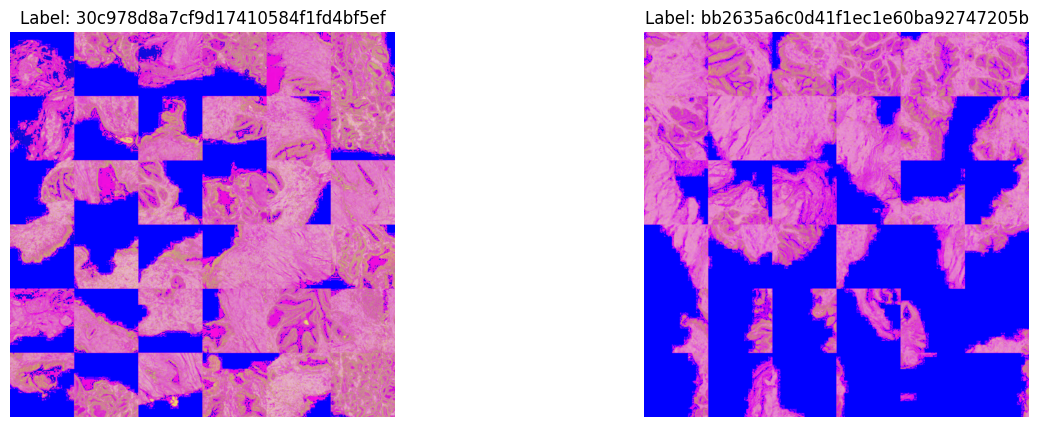

In [17]:
import matplotlib.pyplot as plt

data_iter = iter(train_loader)
images, labels, ids = next(data_iter)

def denormalize(image):
    image = image.numpy().transpose((1, 2, 0))
    image = (image - image.min()) / (image.max() - image.min())
    return image

fig, axes = plt.subplots(1, batch_size, figsize=(15, 5))
for i in range(batch_size):
    img = denormalize(images[i])
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Label: {ids[i]}")

plt.show()


In [18]:
model = EfficientNet(
    backbone=backbone_model,
    output_dimensions=output_classes,
    pre_trained_model=pretrained_model
)
model = model.to(device)

Loaded pretrained weights for efficientnet-b0


In [19]:
optimizer = optim.Adam(model.parameters(), lr = init_lr / warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs - warmup_epochs)
scheduler = GradualWarmupScheduler(optimizer, multiplier = warmup_factor, total_epoch = warmup_epochs, after_scheduler=scheduler_cosine)
save_path = f'models/with-noise-hsv.pth'

In [20]:
train_model(
    model=model,
    epochs=n_epochs,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_loader,
    valid_dataloader=valid_loader,
    checkpoint=model_checkpoint,
    device=device,
    loss_function=loss_function,
    path_to_save_metrics="logs/with-noise-hsv.txt",
    path_to_save_model=save_path
)

Epoch 1/15



100%|██████████| 903/903 [04:49<00:00,  3.12it/s]


Salvando o melhor modelo... 0.0 -> 0.7065431449585159
Epoch 2/15



100%|██████████| 903/903 [04:46<00:00,  3.15it/s]


Salvando o melhor modelo... 0.7065431449585159 -> 0.7330081599799658
Epoch 3/15



100%|██████████| 903/903 [04:44<00:00,  3.17it/s]


Salvando o melhor modelo... 0.7330081599799658 -> 0.8050106453889597
Epoch 4/15



100%|██████████| 903/903 [04:46<00:00,  3.15it/s]


Salvando o melhor modelo... 0.8050106453889597 -> 0.8162351383031474
Epoch 5/15



100%|██████████| 903/903 [04:40<00:00,  3.21it/s]


Salvando o melhor modelo... 0.8162351383031474 -> 0.8251371867182156
Epoch 6/15



100%|██████████| 903/903 [04:57<00:00,  3.03it/s]


Epoch 7/15



100%|██████████| 903/903 [05:07<00:00,  2.94it/s]


Epoch 8/15



100%|██████████| 903/903 [04:48<00:00,  3.13it/s]


Salvando o melhor modelo... 0.8251371867182156 -> 0.825468567217442
Epoch 9/15



100%|██████████| 903/903 [04:48<00:00,  3.13it/s]


Salvando o melhor modelo... 0.825468567217442 -> 0.8342362412194848
Epoch 10/15



100%|██████████| 903/903 [04:45<00:00,  3.17it/s]


Epoch 11/15



100%|██████████| 903/903 [04:36<00:00,  3.27it/s]


Salvando o melhor modelo... 0.8342362412194848 -> 0.8365153245455447
Epoch 12/15



100%|██████████| 903/903 [04:34<00:00,  3.28it/s]


Epoch 13/15



100%|██████████| 903/903 [04:36<00:00,  3.26it/s]


Epoch 14/15



100%|██████████| 903/903 [04:32<00:00,  3.32it/s]


Epoch 15/15



100%|██████████| 903/903 [04:36<00:00,  3.27it/s]
